In [ ]:
!gdown 1CIcYzumHyrbmnA7WjYbY64asECx0RzrP
!gdown 1trTs03tIKSmB3eOI3ERRcaW4myz7ZwvH
!pip install dill
!pip install phik

Downloading...
From: https://drive.google.com/uc?id=1CIcYzumHyrbmnA7WjYbY64asECx0RzrP
To: /content/heart_adapt_train.csv
100% 26.7k/26.7k [00:00<00:00, 52.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1trTs03tIKSmB3eOI3ERRcaW4myz7ZwvH
To: /content/heart_adapt_test.csv
100% 9.05k/9.05k [00:00<00:00, 21.8MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 8.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import dill as pickle
import requests
import json
import warnings
import phik
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

pd.set_option('display.max_columns', 50)

оберните весь конвейер преобразований в Pipeline

подберите оптимальный вариант прогнозной модели с помощью GridSearchCV

примените обученный на тренировочных данных конвейер к тестовым данным, никак не предобрабатывая их, а лишь загрузив из файла и отделив целевой признак от остальных

получите на тестовой части качество не ниже 0.87 по метрике ROCAUC

In [ ]:
df = pd.read_csv('heart_adapt_train.csv')
df.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
65,66.0,M,ASY,150.0,NaN,0,Normal,108,Y,2.0,Flat,1
514,49.0,M,NAP,120.0,188.0,0,Normal,139,N,2.0,Flat,1
197,44.0,M,ASY,135.0,491.0,0,Normal,135,N,0.0,Flat,1
451,55.0,F,ATA,130.0,394.0,0,LVH,150,N,0.0,Up,0
473,NaN,M,ASY,140.0,207.0,0,LVH,138,Y,1.9,Up,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             533 non-null    float64
 1   Sex             589 non-null    object 
 2   ChestPainType   589 non-null    object 
 3   RestingBP       588 non-null    float64
 4   Cholesterol     462 non-null    float64
 5   FastingBS       589 non-null    int64  
 6   RestingECG      589 non-null    object 
 7   MaxHR           589 non-null    int64  
 8   ExerciseAngina  589 non-null    object 
 9   Oldpeak         589 non-null    float64
 10  ST_Slope        589 non-null    object 
 11  HeartDisease    589 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 55.3+ KB


In [ ]:
df.isnull().sum()

Age                56
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       127
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

interval columns not set, guessing: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


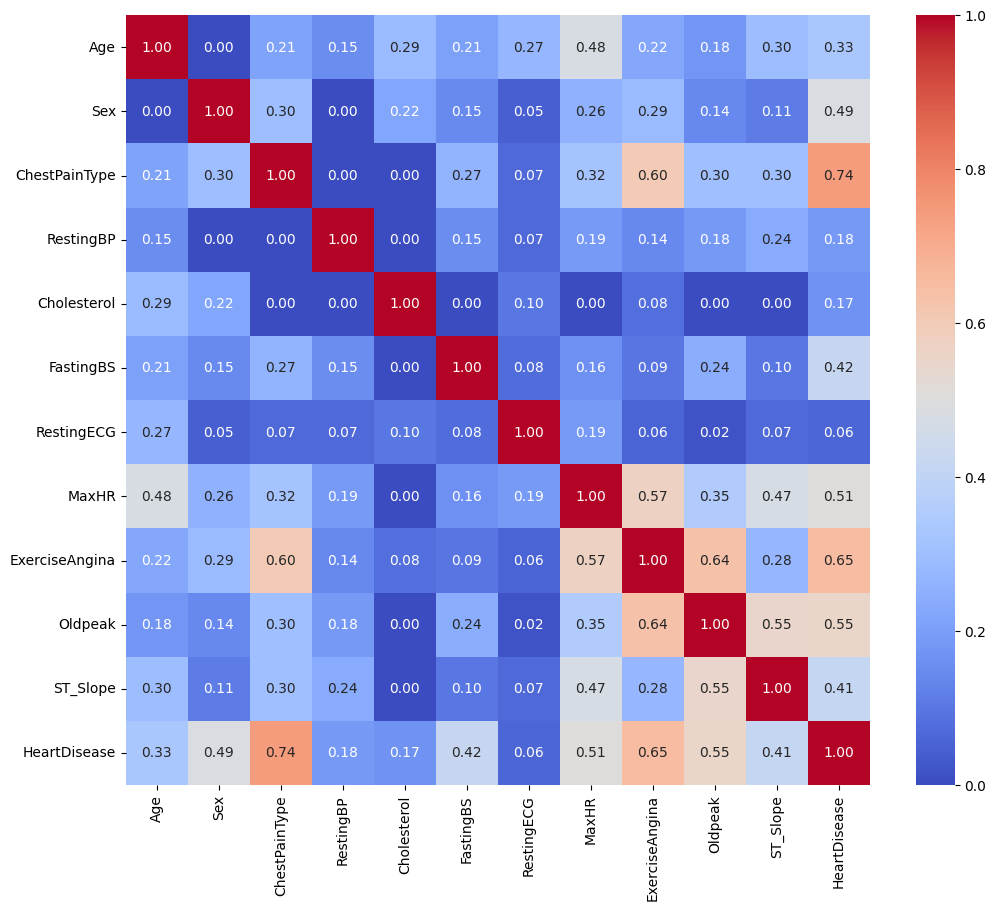

In [ ]:
correlation_matrix = df.phik_matrix()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')

plt.show()

У большинства признаков есть низкая корреляция, выделяется ЭКГ покоя с минимальной корреляцией и тип грудной боли с максимальной.

In [ ]:
train_features = df.drop(['HeartDisease'], axis=1)
train_target =  df['HeartDisease']

In [ ]:
train_target.value_counts()

1    381
0    208
Name: HeartDisease, dtype: int64

Классы не сбалансированны

In [ ]:
features_train, features_val, target_train, target_val = train_test_split(train_features, train_target, test_size=0.3, random_state=43)

In [ ]:
object_columns = list(df.select_dtypes(include=['object']).columns)
types_all = sorted(set(pd.concat([features_train[col] for col in object_columns]).dropna()))

In [ ]:
class CustomOHE(TransformerMixin, BaseEstimator):

    def __init__(self,types_all):
        self.types_all = types_all
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.reset_index(drop=True)

        ohe_types = pd.DataFrame.from_dict(
            list(
                X
                .apply(
                    lambda f: dict([
                        (
                            t, 1 if f['Sex'] == t or f['ChestPainType'] == t or f['RestingECG'] == t or f['ExerciseAngina'] == t or f['ST_Slope'] == t else 0
                        )
                        for t in self.types_all
                    ]),
                    axis=1
                )
            )
        )

        X = pd.concat([X.drop(['Sex', 'ChestPainType','RestingECG','ExerciseAngina','ST_Slope'], axis=1), ohe_types], axis=1)
        return X

In [ ]:
ohe = CustomOHE(types_all)
new_df = ohe.fit_transform(features_train)
new_df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ASY,ATA,Down,F,Flat,LVH,M,N,NAP,Normal,ST,TA,Up,Y
0,67.0,120.0,229.0,0,129,2.6,1,0,0,0,1,1,1,0,0,0,0,0,0,1
1,60.0,160.0,NaN,1,149,0.4,1,0,0,0,1,0,1,1,0,1,0,0,0,0
2,49.0,115.0,265.0,0,175,0.0,0,0,0,0,1,0,1,1,1,1,0,0,0,0
3,63.0,124.0,197.0,0,136,0.0,1,0,0,1,1,0,0,0,0,1,0,0,0,1
4,70.0,160.0,269.0,0,112,2.9,0,0,0,0,1,0,1,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,41.0,120.0,295.0,0,170,0.0,0,1,0,0,0,0,1,1,0,1,0,0,1,0
408,77.0,124.0,171.0,0,110,2.0,1,0,0,0,0,0,1,0,0,0,1,0,1,1
409,57.0,140.0,NaN,0,120,2.0,1,0,0,0,1,0,1,0,0,1,0,0,0,1
410,38.0,145.0,292.0,0,130,0.0,0,0,0,0,0,0,1,1,1,1,0,0,1,0


In [ ]:
class MedianImputer(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.medians = None

    def fit(self, X, y=None):
        self.medians = X.median()
        return self

    def transform(self, X):
        X = X.fillna(self.medians)
        return X

In [ ]:
mi = MedianImputer()
new_df = mi.fit_transform(new_df)
new_df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ASY,ATA,Down,F,Flat,LVH,M,N,NAP,Normal,ST,TA,Up,Y
0,67.0,120.0,229.0,0,129,2.6,1,0,0,0,1,1,1,0,0,0,0,0,0,1
1,60.0,160.0,242.0,1,149,0.4,1,0,0,0,1,0,1,1,0,1,0,0,0,0
2,49.0,115.0,265.0,0,175,0.0,0,0,0,0,1,0,1,1,1,1,0,0,0,0
3,63.0,124.0,197.0,0,136,0.0,1,0,0,1,1,0,0,0,0,1,0,0,0,1
4,70.0,160.0,269.0,0,112,2.9,0,0,0,0,1,0,1,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,41.0,120.0,295.0,0,170,0.0,0,1,0,0,0,0,1,1,0,1,0,0,1,0
408,77.0,124.0,171.0,0,110,2.0,1,0,0,0,0,0,1,0,0,0,1,0,1,1
409,57.0,140.0,242.0,0,120,2.0,1,0,0,0,1,0,1,0,0,1,0,0,0,1
410,38.0,145.0,292.0,0,130,0.0,0,0,0,0,0,0,1,1,1,1,0,0,1,0


In [ ]:
scaler = StandardScaler()
scaler.fit(new_df)
features_train_scaled = pd.DataFrame(scaler.transform(new_df), columns=scaler.feature_names_in_)
features_train_scaled.sample(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ASY,ATA,Down,F,Flat,LVH,M,N,NAP,Normal,ST,TA,Up,Y
18,0.174134,-0.203418,-0.540092,-0.592300,1.191269,-0.930636,-1.254990,-0.432805,-0.248708,2.069312,-1.124160,-0.509842,-2.069312,0.966578,2.053093,-1.169537,1.905049,-0.201008,1.26791,-0.966578
353,0.174134,-0.203418,0.566190,-0.592300,-0.231233,0.037357,-1.254990,-0.432805,-0.248708,-0.483252,-1.124160,-0.509842,0.483252,-1.034578,2.053093,0.855039,-0.524921,-0.201008,1.26791,1.034578
300,0.844633,0.345065,-0.093698,1.688333,0.361476,-0.930636,-1.254990,-0.432805,-0.248708,2.069312,0.889553,-0.509842,-2.069312,0.966578,-0.487070,0.855039,-0.524921,4.974937,-0.78870,-0.966578
1,0.621134,1.442030,-0.093698,1.688333,0.598559,-0.543439,0.796819,-0.432805,-0.248708,-0.483252,0.889553,-0.509842,0.483252,0.966578,-0.487070,0.855039,-0.524921,-0.201008,-0.78870,-0.966578
383,-0.384615,-0.313114,-0.093698,1.688333,-0.349775,0.230956,0.796819,-0.432805,-0.248708,-0.483252,0.889553,-0.509842,0.483252,-1.034578,-0.487070,-1.169537,1.905049,-0.201008,-0.78870,1.034578


In [ ]:
pipe = Pipeline([
    ('ohe_types', CustomOHE(types_all)),
    ('median_imputer', MedianImputer()),
    ('scaler', StandardScaler()),
    ('classify', DecisionTreeClassifier(class_weight='balanced', random_state=0))
])

params = [
    {'classify': [LogisticRegression(class_weight='balanced', random_state=0)]},
    {'classify': [DecisionTreeClassifier(class_weight='balanced', random_state=0)], 'classify__max_depth': [2, 5, 10, 20]}
]

grid_search = GridSearchCV(pipe, param_grid=params, cv=5, scoring='roc_auc')
grid_search.fit(X=features_train, y=target_train)
print(
    'Качество модели на валидационной выборке c лучшей моделью:',
    {roc_auc_score(target_val, grid_search.predict_proba(features_val)[:, 1])}
)

Качество модели на валидационной выборке c лучшей моделью: {0.9605413105413106}


In [ ]:
df_test = pd.read_csv('heart_adapt_test.csv')

In [ ]:
features_test = df_test.drop(['HeartDisease'], axis=1)
target_test =  df_test['HeartDisease']

In [ ]:
print(
    'Качество модели на тестовой выборке c лучшей моделью:',
    {roc_auc_score(target_test, grid_search.predict_proba(features_test)[:, 1])}
)

Качество модели на тестовой выборке c лучшей моделью: {0.9012373453318335}


Вывод признаков по важности

In [ ]:
best_model = grid_search.best_estimator_
coefficients = best_model['classify'].coef_

feature_list = list(features_train_scaled.columns)

feature_coefficients = [(coeff, feature) for feature, coeff in zip(feature_list, coefficients[0])]

feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[0]), reverse=True)

for coeff, feature in feature_coefficients:
    print(f'Признак: {feature}, Коэффициент: {coeff}')

Признак: FastingBS, Коэффициент: 0.6639565933019573
Признак: Flat, Коэффициент: 0.644565028237114
Признак: Up, Коэффициент: -0.6072045874635905
Признак: ASY, Коэффициент: 0.4866814962732697
Признак: F, Коэффициент: -0.31800263484377517
Признак: M, Коэффициент: 0.31800263484377517
Признак: ATA, Коэффициент: -0.2570618154801566
Признак: NAP, Коэффициент: -0.2537483756080395
Признак: TA, Коэффициент: -0.2256554881912114
Признак: MaxHR, Коэффициент: -0.2230177785770941
Признак: Cholesterol, Коэффициент: 0.21120913424964133
Признак: Oldpeak, Коэффициент: 0.17715013435290305
Признак: Age, Коэффициент: 0.1638486394427072
Признак: N, Коэффициент: -0.14122628240432442
Признак: Y, Коэффициент: 0.14122628240432442
Признак: Down, Коэффициент: -0.1060640929976561
Признак: RestingBP, Коэффициент: 0.10118051607614294
Признак: LVH, Коэффициент: -0.07104917137886281
Признак: ST, Коэффициент: 0.04056497571993309
Признак: Normal, Коэффициент: 0.024410056279985166


In [ ]:
d = {}
for i in object_columns:
  d[i] = list(df[i].unique())
d

{'Sex': ['M', 'F'],
 'ChestPainType': ['NAP', 'ATA', 'ASY', 'TA'],
 'RestingECG': ['Normal', 'LVH', 'ST'],
 'ExerciseAngina': ['N', 'Y'],
 'ST_Slope': ['Up', 'Flat', 'Down']}

In [ ]:
cat = {}
for coeff, feature in feature_coefficients:
    cat[feature] = abs(coeff)
cat

{'FastingBS': 0.6639565933019573,
 'Flat': 0.644565028237114,
 'Up': 0.6072045874635905,
 'ASY': 0.4866814962732697,
 'F': 0.31800263484377517,
 'M': 0.31800263484377517,
 'ATA': 0.2570618154801566,
 'NAP': 0.2537483756080395,
 'TA': 0.2256554881912114,
 'MaxHR': 0.2230177785770941,
 'Cholesterol': 0.21120913424964133,
 'Oldpeak': 0.17715013435290305,
 'Age': 0.1638486394427072,
 'N': 0.14122628240432442,
 'Y': 0.14122628240432442,
 'Down': 0.1060640929976561,
 'RestingBP': 0.10118051607614294,
 'LVH': 0.07104917137886281,
 'ST': 0.04056497571993309,
 'Normal': 0.024410056279985166}

Вывод изначальных признаков по важности

In [ ]:
res = {}
for i in cat:
  if i in list(df.select_dtypes(include=['float','int']).columns):
    res[i] = cat[i]
  else:
    for j in d:
      if i in d[j]:
        res[j] = res.get(j, 0) + cat[i]
sorted_res = dict(sorted(res.items(), key=lambda item: item[1]))
sorted_res

{'RestingBP': 0.10118051607614294,
 'RestingECG': 0.13602420337878107,
 'Age': 0.1638486394427072,
 'Oldpeak': 0.17715013435290305,
 'Cholesterol': 0.21120913424964133,
 'MaxHR': 0.2230177785770941,
 'ExerciseAngina': 0.28245256480864883,
 'Sex': 0.6360052696875503,
 'FastingBS': 0.6639565933019573,
 'ChestPainType': 1.223147175552677,
 'ST_Slope': 1.3578337086983607}

Получилось добится требуемого качества, подтвердилась сильная взаимосвязь ChestPainType и заболевания, наиболее важным в постановке диагноза является ST_Slope, также интересно что пол пациента находится на 4 м месте по важности